In [9]:
from tqdm import tqdm
import requests
import zipfile
import io
import os
import shutil
import json
import csv
import random
import tarfile

from matplotlib import pyplot as plt

import cv2
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.models as models
import numpy as np

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [10]:
DATA_DIR= "/home/ubuntu/outdoor"
IMAGES_DIR= DATA_DIR + "/images"
TRAIN_DIR= DATA_DIR + "/train"
VAL_DIR= DATA_DIR + "/val"
DATA_EXT = ".zip"

if not os.path.isdir(DATA_DIR): 
    os.mkdir(DATA_DIR)

In [11]:
opts = {
    'image_size':224,
    'rgb_mean':[0.3820, 0.4122, 0.4279],
    'rgb_std':[0.2998, 0.2836, 0.2907],
}

In [45]:
model = torch.load('model.pth')

model.classes = 3

model.classifier = nn.Linear(1920, 3)
for param in model.parameters():
    param.requires_grad = False
    
model.to(device)
model.eval()

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [48]:
##From: https://towardsdatascience.com/how-to-train-an-image-classifier-in-pytorch-and-use-it-to-perform-basic-inference-on-single-images-99465a1e9bf5

test_transforms = transforms.Compose([
        transforms.Resize(opts['image_size']),
        transforms.CenterCrop(opts['image_size']),
        transforms.ToTensor(),
        transforms.Normalize(opts['rgb_mean'], opts['rgb_std'])
    ])

def predict_image(image):
    image_tensor = test_transforms(image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    with torch.no_grad():
        input = image_tensor.to(device)
        output = model(input)
        index = output.data.cpu().numpy().argmax()
        return index

def get_random_images(num):
    data = datasets.ImageFolder(TRAIN_DIR, transform=test_transforms)
    classes = data.classes
    indices = list(range(len(data)))
    np.random.shuffle(indices)
    idx = indices[:num]
    from torch.utils.data.sampler import SubsetRandomSampler
    sampler = SubsetRandomSampler(idx)
    loader = torch.utils.data.DataLoader(data, 
                   sampler=sampler, batch_size=num)
    dataiter = iter(loader)
    images, labels = next(dataiter)
    return images, labels

{0: 0.0, 1: 0.0, 2: 0.5142857142857142}


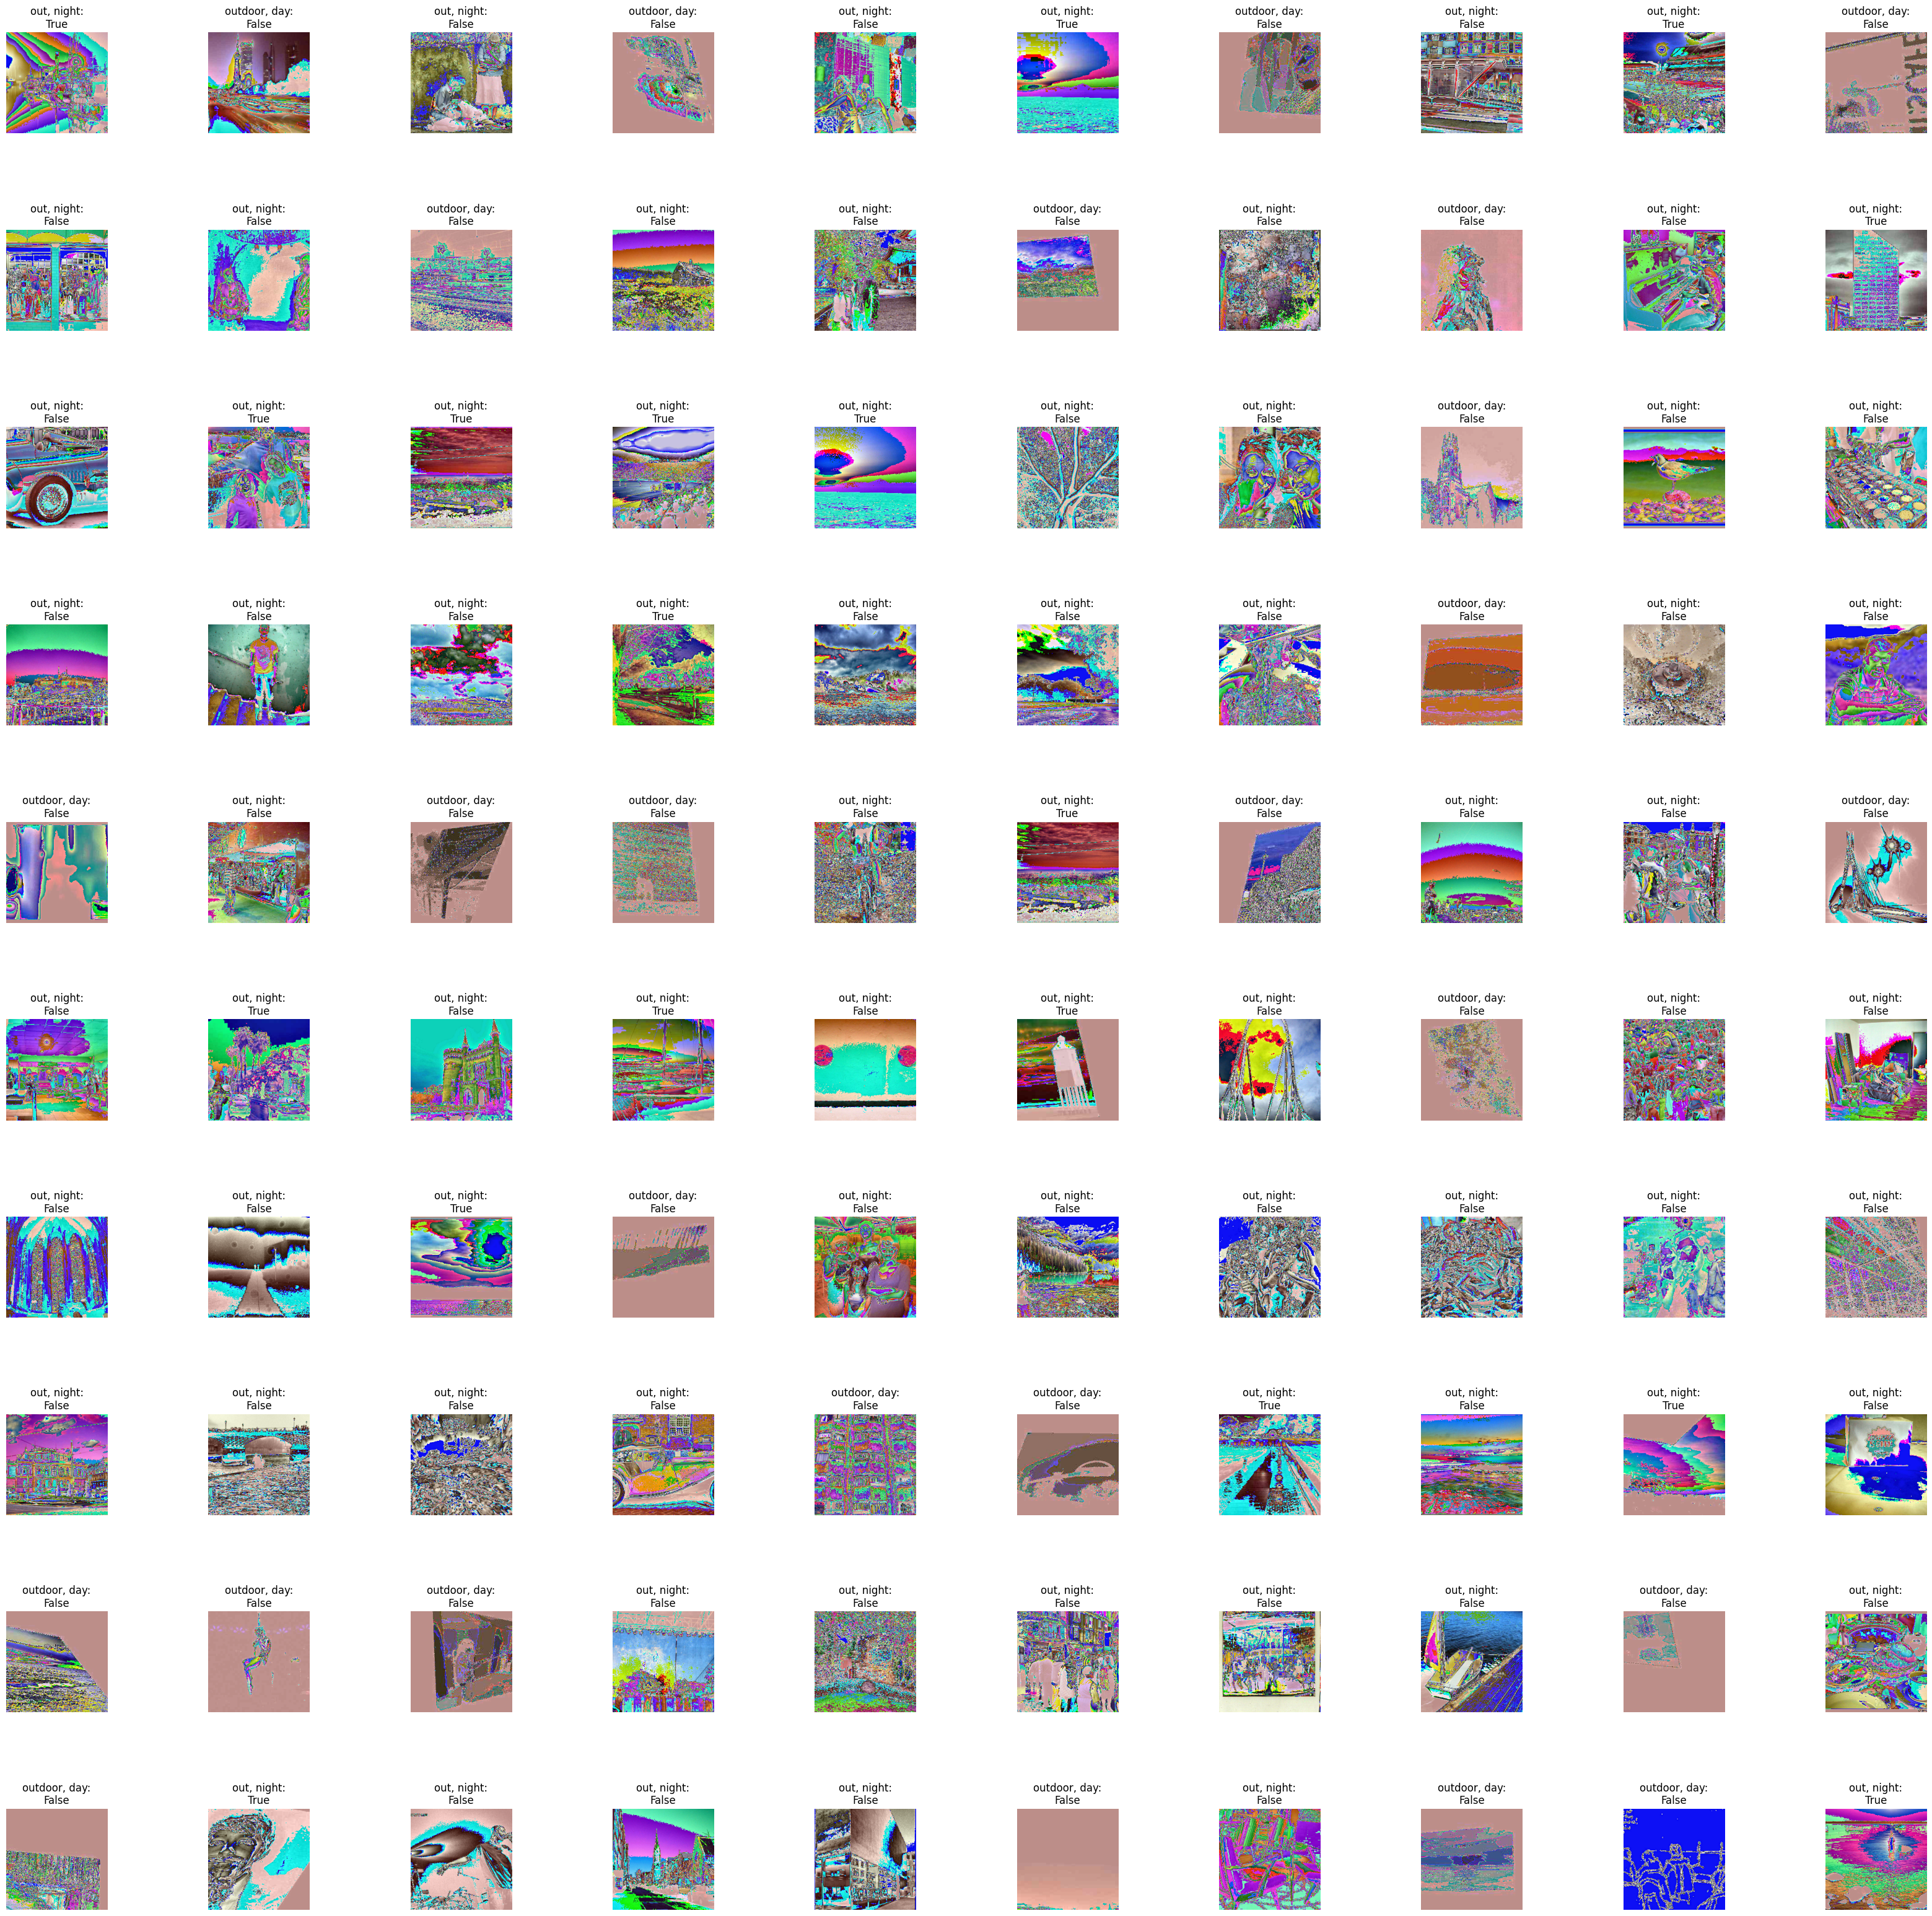

In [49]:
classes = ["indoor","outdoor, day","out, night"]

num_images = 100
to_pil = transforms.ToPILImage()
images, labels = get_random_images(num_images)
fig=plt.figure(figsize=(40,40))
results={0:[0,0],1:[0,0],2:[0,0]}
for ii in range(len(images)):
    image = to_pil(images[ii])
    index = predict_image(image)
    sub = fig.add_subplot(int(len(images)/10), 10, ii+1)
    res = int(labels[ii]) == index
    results[int(labels[ii])][int(res)] += 1
    sub.set_title(str(classes[index]) + ":\n" + str(res))
    plt.axis('off')
    plt.imshow(image)

for r in results:
    results[r] = results[r][1] / (results[r][1] + results[r][0])
    
print(results)
    
plt.subplots_adjust(wspace=1,
                    hspace=.5)
plt.show()